## Auto Regressive for Feature Extraction by Lags of time series
 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
eeg_data = pd.read_csv('Subject_1_VR.csv')
eeg_data.head()

,CH 1,CH 2,CH 3,CH 4,CH 6,CH 7,CH 8
0,1.918465e-12,1.520561e-12,1.714184e-13,-3.422151e-12,-6.483702e-14,1.247003e-12,1.392664e-12
1,-4.509159e+00,-6.211227e+00,-5.730144e+00,-6.112785e+00,2.984797e+01,-5.506791e+00,-3.553580e+00
2,3.025560e-01,-7.839167e-02,1.224983e+00,4.012415e+00,4.861158e+01,-8.120446e+00,3.683355e+00
3,-1.714121e-01,-6.277584e+00,-4.990203e+00,5.355046e-01,4.095041e+01,-1.461105e+01,-1.017404e+01
4,-1.554068e+00,-1.385413e+01,-6.776541e+00,-1.139681e+00,2.500130e+01,-2.130122e+01,-2.209927e+01


In [3]:
eeg_data1 = eeg_data['CH 4']

In [ ]:
eeg_data1.head()

0   -3.422151e-12
1   -6.112785e+00
2    4.012415e+00
3    5.355046e-01
4   -1.139681e+00
Name: CH 4, dtype: float64

In [ ]:
type(eeg_data1)

pandas.core.series.Series

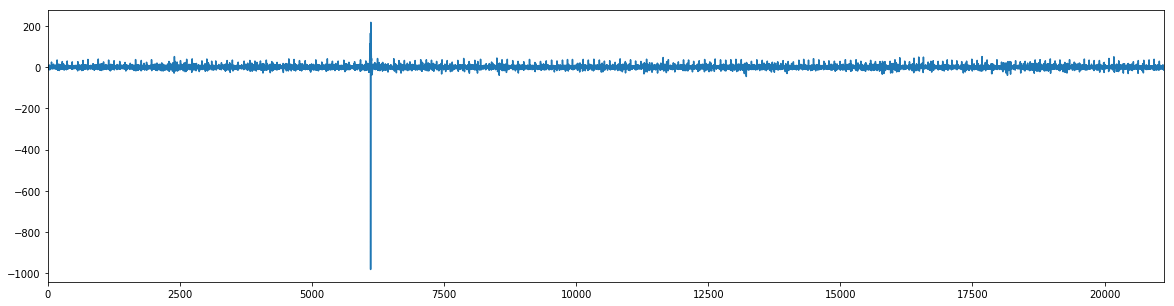

In [ ]:
eeg_data1.plot(figsize=(20,5)) ## CSV file data

#### Testing for Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
#checking data is stationary or not
adf_check(eeg_data1)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

### Auto correlation

In [ ]:
fig, ax = plt.subplots(figsize=(70, 20))
plot_acf(eeg_data1[:1000], ax=ax);

# Lag of time series for 15

In [ ]:
#take difference 1
diff = eeg_data1.diff(periods=15)
# integrated of order 1 because here we are taking 1 lag/1 time difference
# it's denoted by d(diff), one of the parameter of ARIMA model

diff.dropna(inplace=True)
diff


In [ ]:
fig, ax = plt.subplots(figsize=(50, 20))
plot_acf(diff[:1000], ax=ax);

In [ ]:
diff.plot(figsize=(20,5))

# Lags of time series from 16 to 20

In [ ]:
df = pd.DataFrame(eeg_data1.copy())
df.columns = ["y"]

# Adding the lag of the target variable from 16 steps back up to 20
for i in range(16, 21):
    df["lag_{}".format(i)] = df.y.shift(i)

In [ ]:
df.dropna()